In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import time 
from scipy import stats
import rebound
from scipy.special import gamma
from scipy.stats import norm, ks_2samp

# Merge dataframes

In [3]:
file_path = "/mnt/scratch-lustre/nhussain/data/distributions/Long300/"#"../../../LongScaleCsvs/"
planet_systems = np.loadtxt(file_path +"Order.txt", dtype = str)
print(planet_systems.shape)

(266,)


In [4]:
#save data
#info.to_csv("../../Figures/MCMCFigures/ProbabilityTable_Fixed_Covariences_{0}.csv".format(info.shape[0]))

#FILTER DATA (between 1e4 and 1e7)
info = pd.read_csv("../../Figures/MCMCFigures/ProbabilityTable_Fixed_Covariences_266.csv", index_col=0)

#fully integrated data
short_feats = pd.read_csv("../../csvs/deltatimes.csv", index_col =0 )
subsystem = info["ID"].values.astype(int)
sub_short = short_feats.loc[subsystem]
print sub_short.shape

#filtered data params
filtered = sub_short[ (sub_short["t"]>1e4) & (sub_short["t"]<1e7) &
                    (sub_short["t_shadow"]>1e4 ) & (sub_short["t_shadow"]<1e7) ] 

print(filtered.shape)
filtered_inds = filtered.index
#df.loc[df['column_name'].isin(some_values)]
valid = info.loc[info["ID"].isin(filtered_inds)] 
valid.head()

(266, 3)
(248, 3)


,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
0,1007,0.130767,5.584131,0.461519,0.014201,0.010451,2.201230e-08
1,1021,0.185651,6.008010,0.330157,0.010570,0.007475,6.242409e-09
2,1025,0.154975,5.797448,0.387122,0.012399,0.008591,1.134396e-08
3,1041,0.123930,5.732675,0.489208,0.015449,0.010785,2.773702e-08
4,10518,0.143696,6.469809,0.431217,0.013868,0.009608,1.775222e-08


In [5]:
#info = pd.read_csv("../../Figures/MCMCFigures/Weibull_MCMC_Params_266.csv", index_col = 0)
info = pd.read_csv("../../Figures/MCMCFigures/Weibull_Parameters_266.csv", index_col =0 )
info['EV'] = info['Location'] + info['Alpha']*gamma(1+1/info['Gamma']) #EV of weibull
info.tail()

,ID,Gamma,Location,Alpha,EV
261,8462.0,2.096314,4.459373,1.199551e+00,5.521821
262,8582.0,0.184163,1.996260,1.191003e+00,304.531030
263,8744.0,0.833252,4.705257,1.546389e-01,4.875650
264,91.0,1.634222,4.750447,8.097842e-01,5.475133
265,99.0,0.999930,7.983125,8.810369e-16,7.983125


In [6]:
df = pd.merge(valid, info, on='ID', how='inner')
df.head()

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant,Gamma,Location,Alpha,EV
0,1007,0.130767,5.584131,0.461519,0.014201,0.010451,2.201230e-08,2.614027,4.447527,1.283371,5.587615
1,1021,0.185651,6.008010,0.330157,0.010570,0.007475,6.242409e-09,3.269655,4.989150,1.129664,6.002008
2,1025,0.154975,5.797448,0.387122,0.012399,0.008591,1.134396e-08,2.249906,4.965337,0.938566,5.796653
3,1041,0.123930,5.732675,0.489208,0.015449,0.010785,2.773702e-08,1.856930,4.863439,0.972277,5.726901
4,10518,0.143696,6.469809,0.431217,0.013868,0.009608,1.775222e-08,1.596694,5.781111,0.761953,6.464390


In [7]:
df.shape

(248, 11)

# Plot distributions. Red = gamma, black = gaussian

In [8]:
def plot_hists(planet_systems):
    ncol, nrow = 3,len(planet_systems)//3+1
    fig, axarr = plt.subplots(ncols=ncol,nrows=nrow)
    fig.set_size_inches((15, nrow*3))
    for jj , planet_sys in enumerate(planet_systems[:ncol*nrow]):
        data =pd.read_csv(file_path+'Sys_{0}_1e8.csv'.format(planet_sys), index_col = 0)
        
        data = data[data["t"]<1e8]
        data["logt"] = np.log10(data["t"])
        name = str(planet_sys)
        # make guassian
        gamma, mean, alpha =  df[df["ID"]==int(name)][["Gamma","Location", "Alpha"]].values[0]
        print(gamma, mean, alpha)
        x = np.linspace(data["logt"].min(), data["logt"].max(), 100)
        vals = stats.weibull_min.pdf(x,c=gamma,loc=mean,scale = alpha)
        axarr[jj//ncol, jj%ncol ].plot(x, vals, linewidth = 4, color = "red")
        mean, sigma =  df[df["ID"]==int(name)][["Mean", "Sigma"]].values[0]

        x = np.linspace(mean - sigma*4, mean+sigma*4, 100)
        rv = norm(loc = mean, scale = sigma)
        axarr[jj//ncol, jj%ncol ].plot(x, rv.pdf(x), linewidth = 4, color = "black")
        
        data.hist("logt",  ax = axarr[jj//ncol, jj%ncol],  label = name, alpha = 0.7, normed = 1, color = "purple", edgecolor = "black", bins = 20)
        axarr[jj//ncol, jj%ncol ].set_title(name)
        edges = axarr[jj//ncol, jj%ncol ].axes.get_ylim() 
        
    plt.show()
    plt.close(fig)

In [9]:
df[df['EV']<4]

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant,Gamma,Location,Alpha,EV
8,1124,0.136483,4.170971,0.455038,0.014453,0.010170,2.159837e-08,1.130110,3.182193,0.816437,3.963255
32,1266,0.156639,3.776559,0.389771,0.012615,0.008841,1.243547e-08,1.825756,3.106470,0.758837,3.780851
171,2173,0.152814,3.785841,0.393255,0.012247,0.008799,1.160170e-08,2.158597,2.969858,0.921916,3.786311


(1.1301103911200001, 3.1821931082899999, 0.81643656683099997)
(1.82575623718, 3.1064698480699997, 0.75883738905699993)
(2.1585966320900001, 2.9698583209700002, 0.92191623334499995)


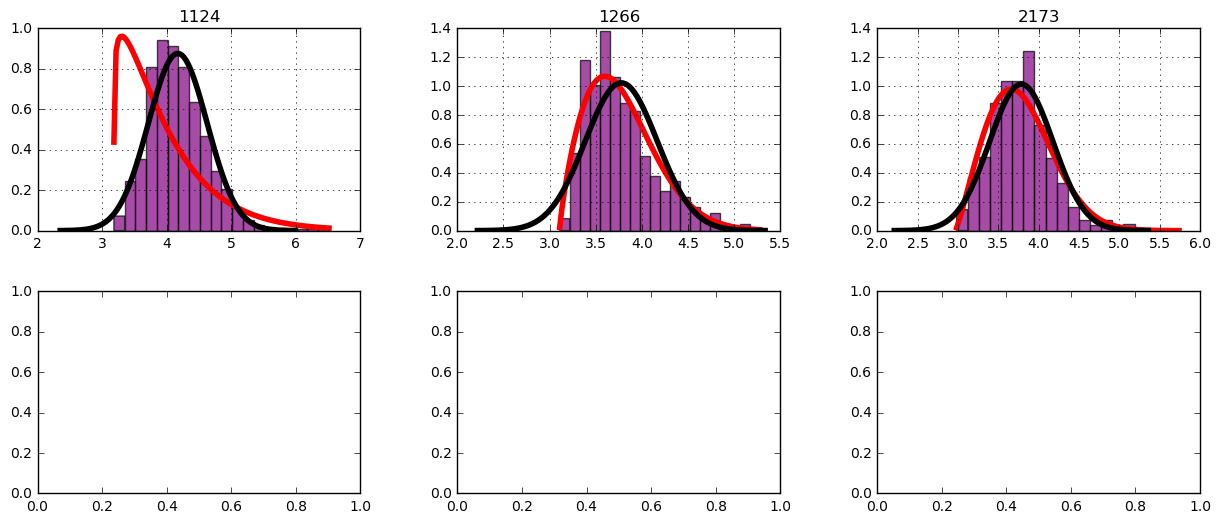

In [10]:
plot_hists(df[df['EV']<4]['ID'])

# Plot Orbits

In [11]:
from rebound.plotting import OrbitPlotOneSlice
def plotorbits(IDs):
    ncol, nrow = 3,len(IDs)//3+1
    fig, axarr = plt.subplots(ncols=ncol,nrows=nrow)
    fig.set_size_inches((15, nrow*3))
    for jj , ID in enumerate(IDs[:ncol*nrow]):
        file = "/mnt/scratch-lustre/nhussain/data/distributions/Sys_{0}_1e8/initial_conditions/ic{1:0=7d}.bin".format(ID, 0)
        sim = rebound.Simulation.from_file(file)
        axarr[jj//ncol, jj%ncol].set_aspect('equal')
        OrbitPlotOneSlice(sim, axarr[jj//ncol, jj%ncol], trails=True) 
        

/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


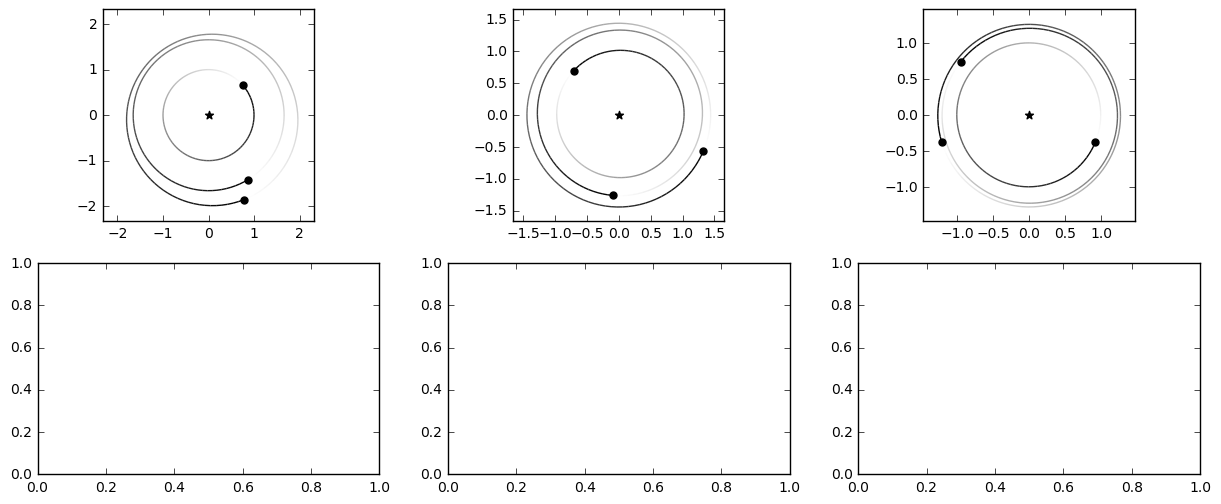

In [12]:
plotorbits(df[df['EV']<4]['ID'])

# Make additional features to plot

In [13]:
def run(row):
    system = int(row['ID'])
    data =pd.read_csv(file_path+'Sys_{0}_1e8.csv'.format(system), index_col = 0)
    mad = np.log10(data['t']).mad()
    mint = np.log10(data['t'].min())
    med = np.log10(data['t'].median())
    f = "/mnt/scratch-lustre/nhussain/data/distributions/Sys_{0}_1e8/initial_conditions/ic{1:0=7d}.bin".format(system, 0)
    
    sim = rebound.Simulation.from_file(f)
    ps = sim.particles
    RH12 = ((ps[1].m+ps[2].m)/3.)**(1./3.)*ps[1].a
    RH23 = ((ps[2].m+ps[3].m)/3.)**(1./3.)*ps[2].a

    minP = min(ps[2].P/ps[1].P, ps[3].P/ps[2].P)
    maxe = max(max(ps[1].e, ps[2].e), ps[3].e)
    minRH = min(RH12, RH23)
    cross1 = (ps[2].a*(1.-ps[2].e)-ps[1].a*(1+ps[1].e))/RH12
    cross2 = (ps[3].a*(1.-ps[3].e)-ps[2].a*(1+ps[2].e))/RH23
    mincross = min(cross1, cross2)
    
    #do tests for only valid systems within the instability time range cuts

    np.random.seed(3)
    data =pd.read_csv("/mnt/scratch-lustre/nhussain/data/distributions/Long300/Sys_{0}_1e8.csv".format(system), index_col = 0)
    del data["Unnamed: 0.1"]
    del data["runstring"]
    data = data[data["t"]<1e8]
    data = np.log10(data["t"].values)

    # normal we want to match
    test = np.random.normal(loc=row["Mean"], scale=row["Sigma"], size = data.shape[0])

    #ks test
    try:
        statistic, KSpval = ks_2samp(data, test)
    except:
        statistic, KSpval = 0,0
    
    return minP, maxe, minRH, mincross, mint, mad, med, KSpval

In [14]:
df['minP'], df['maxe'], df['minRH'], df['mincross'], df['mint'], df['mad'], df['med'], df['KSpval'] = zip(*df.apply(run, axis=1))
df.head()

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant,Gamma,Location,Alpha,EV,minP,maxe,minRH,mincross,mint,mad,med,KSpval
0,1007,0.130767,5.584131,0.461519,0.014201,0.010451,2.201230e-08,2.614027,4.447527,1.283371,5.587615,1.821521,0.277217,0.027468,3.520517,4.476226,0.366226,5.548418,9.386954e-02
1,1021,0.185651,6.008010,0.330157,0.010570,0.007475,6.242409e-09,3.269655,4.989150,1.129664,6.002008,1.131163,0.004271,0.007287,7.795756,5.030155,0.258951,5.995834,3.072049e-01
2,1025,0.154975,5.797448,0.387122,0.012399,0.008591,1.134396e-08,2.249906,4.965337,0.938566,5.796653,1.066340,0.049713,0.005722,7.274974,4.986394,0.302861,5.768233,2.789818e-02
3,1041,0.123930,5.732675,0.489208,0.015449,0.010785,2.773702e-08,1.856930,4.863439,0.972277,5.726901,1.098957,0.041868,0.011382,2.107808,4.866753,0.381478,5.646139,8.813668e-07
4,10518,0.143696,6.469809,0.431217,0.013868,0.009608,1.775222e-08,1.596694,5.781111,0.761953,6.464390,1.376369,0.132402,0.013379,13.122136,5.798014,0.355084,6.410318,4.772941e-03


In [15]:
df[df['KSpval']<1.e-10]['ID'].values

array([ 1190,  1223,  1230,  1277,  1356,  1364,  1424,  1508,  1601,
        1640,  1742,  1775,  1785,  1819,  1829,  1837,  1880,  1886,
        1928,  1942,  1946,  1957,  1992,  2077,  2215,  2274,  2288,
        2300,  2341,  2364,  2399, 24453, 24930,  4753,  8744])

In [16]:
weirdmask = df['KSpval'] < 1.e-10 #df['ID'].isin(weird_systems)
weird = df[weirdmask]

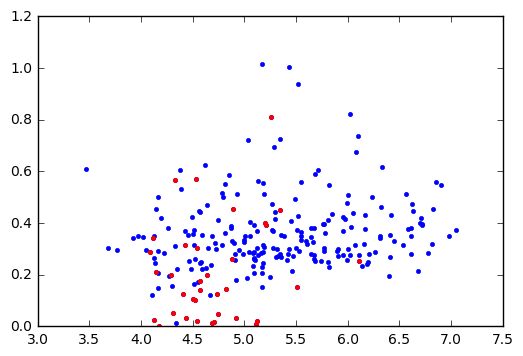

In [17]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(df['med'], df['mad'], 'b.')
ax.plot(weird['med'], weird['mad'], 'r.')

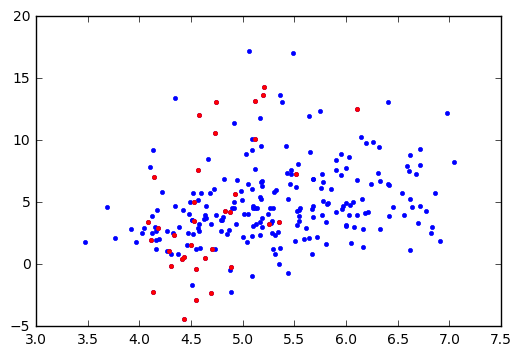

In [18]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(df['med'], df['mincross'], 'b.')
ax.plot(weird['med'], weird['mincross'], 'r.')

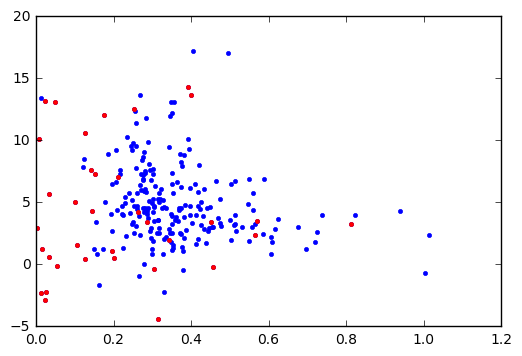

In [19]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(df['mad'], df['mincross'], 'b.')
ax.plot(weird['mad'], weird['mincross'], 'r.')